### Setup

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
from IPython.display import display 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import cv2
import os
import seaborn as sns
from datetime import datetime


### Creating datapaths

In [113]:
path= r"G:\Meu Drive\Meu projeto\csv_analise\top\aversivo\Fiona_d25_teste_snake_1DLC_resnet50_after_surgery_networkNov18shuffle1_300000.csv"
df = pd.read_csv(path, header=[1, 2])

video_path = r"G:\Meu Drive\Meu projeto\csv_analise\top\aversivo\Fiona_d25_teste_snake_1.mp4"
cap = cv2.VideoCapture(video_path) 

### Box area selection

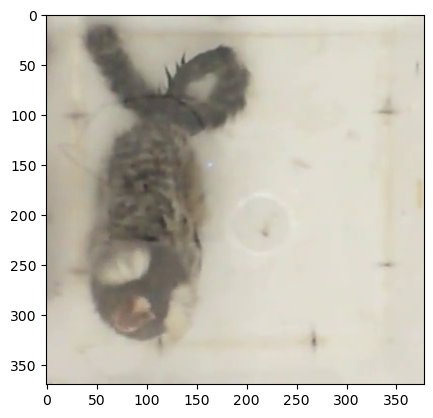

In [114]:
cap = cv2.VideoCapture(video_path) 
numOfFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
chosenFrameIdx = np.random.randint(1, high=numOfFrames)
cap.set(cv2.CAP_PROP_POS_FRAMES, chosenFrameIdx)
res, chosenFrame = cap.read()

original_height, original_width, _ = chosenFrame.shape
display_max_width = 700
ratio = display_max_width / original_width
display_height = int(original_height * ratio)

frame_for_selection = cv2.resize(chosenFrame, (display_max_width, display_height))

roi_small = cv2.selectROI('Select the arena, then press space and enter', frame_for_selection) 

x_scale = original_width / display_max_width
y_scale = original_height / display_height

roi_original_scale = (
    int(roi_small[0] * x_scale),
    int(roi_small[1] * y_scale),
    int(roi_small[2] * x_scale),
    int(roi_small[3] * y_scale)
)

roi_cropped = chosenFrame[int(roi_original_scale[1]):int(roi_original_scale[1]+roi_original_scale[3]), int(roi_original_scale[0]):int(roi_original_scale[0]+roi_original_scale[2])]
plt.imshow(cv2.cvtColor(roi_cropped, cv2.COLOR_BGR2RGB))
plt.show()

cv2.waitKey(0) 
cv2.destroyAllWindows()

arenaSide = (roi_original_scale[2] + roi_original_scale[3]) / 2 
xThresholdLeft = roi_original_scale[0]
xThresholdRight = roi_original_scale[0] + arenaSide
yThresholdUp = roi_original_scale[1]
yThresholdDown = roi_original_scale[1] + arenaSide

### Convert pixel to cm

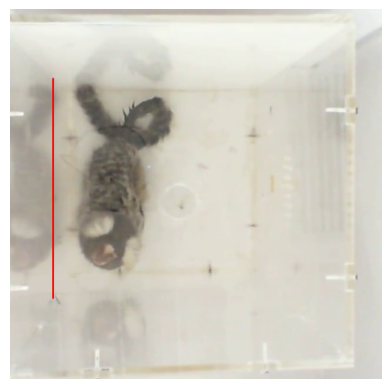

Pixels per cm: 14.384615384615385


In [115]:
py1 = yThresholdDown 
py2 = yThresholdUp
px = xThresholdLeft

frame_with_line = chosenFrame.copy()
cv2.line(frame_with_line, (px, int(py1)), (px, int(py2)), (0, 0, 255), 2)  
frame_with_line_rgb = cv2.cvtColor(frame_with_line, cv2.COLOR_BGR2RGB)
plt.imshow(frame_with_line_rgb)
plt.axis('off') 
plt.show()

pix_per_cm = (py1-py2) / 26 # 26 cm é a distância entre os dois pontos
print(f"Pixels per cm: {pix_per_cm}")

### Filter coordinates

In [116]:
head_x = df[('head', 'x')].values
head_y = df[('head', 'y')].values
nose_x = df[('nose', 'x')].values
nose_y = df[('nose', 'y')].values

head_x_filt = np.where((head_x >= xThresholdLeft) & (head_x <= xThresholdRight), head_x, np.nan)
head_y_filt = np.where((head_y >= yThresholdUp) & (head_y <= yThresholdDown), head_y, np.nan)
nose_x_filt = np.where((nose_x >= xThresholdLeft) & (nose_x <= xThresholdRight), nose_x, np.nan)
nose_y_filt = np.where((nose_y >= yThresholdUp) & (nose_y <= yThresholdDown), nose_y, np.nan)

head_x_cm = head_x_filt  / pix_per_cm
head_y_cm = head_y_filt  / pix_per_cm
nose_x_cm = nose_x_filt  / pix_per_cm
nose_y_cm = nose_y_filt  / pix_per_cm

mask = ~np.isnan(head_x_cm) & ~np.isnan(head_y_cm)
head_x = head_x_cm[mask]
head_y = head_y_cm[mask]
nose_x = nose_x_cm[mask]
nose_y = nose_y_cm[mask]

head_x = pd.Series(head_x).rolling(window=59, min_periods=1, center=True).mean().values
head_y = pd.Series(head_y).rolling(window=59, min_periods=1, center=True).mean().values
nose_x = pd.Series(nose_x).rolling(window=59, min_periods=1, center=True).mean().values
nose_y = pd.Series(nose_y).rolling(window=59, min_periods=1, center=True).mean().values

### Polar plot config

In [117]:
dx = nose_x - head_x
dy = nose_y - head_y

angles_rad = np.arctan2(dy, dx)
angles_deg = (np.degrees(angles_rad) + 360) % 360

bin_size = 20 
bins = np.arange(0, 361, bin_size)
counts, bin_edges = np.histogram(angles_deg, bins=bins)
bin_centers_deg = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2
theta = np.deg2rad(bin_centers_deg)

radii = counts
width = np.deg2rad(bin_size)
colors = plt.cm.viridis(radii / np.max(radii))

### Plot and save

In [144]:
figures_to_save = {}

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
animal_name = 'Fiona'
condition = 'aversive'

filename1 = f'histograma_{animal_name}_{condition}_{timestamp}.png'
filename2 = f'heatmap_{animal_name}_{condition}_{timestamp}.png'
filename3 = f'tracking_{animal_name}_{condition}_{timestamp}.png'
filename4 = f'polar_{animal_name}_{condition}_{timestamp}.png'
filename5 = f'direction_{animal_name}_{condition}_{timestamp}.png'

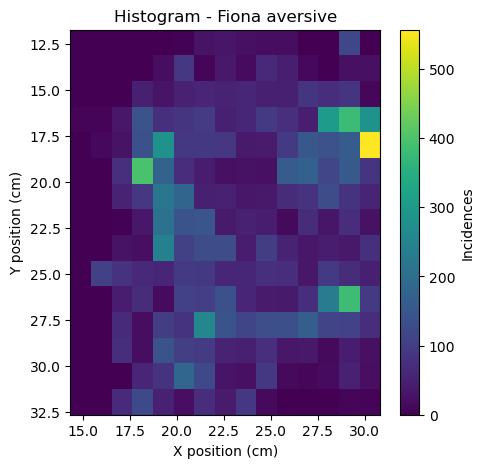

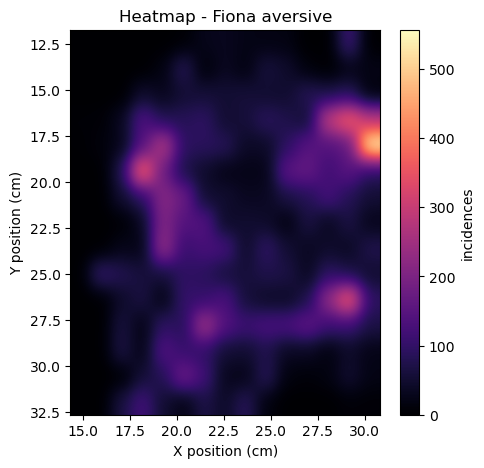

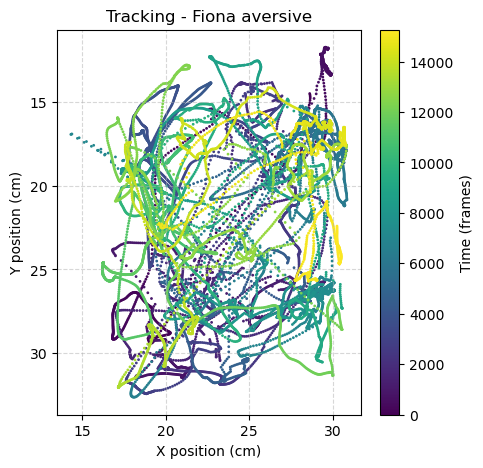

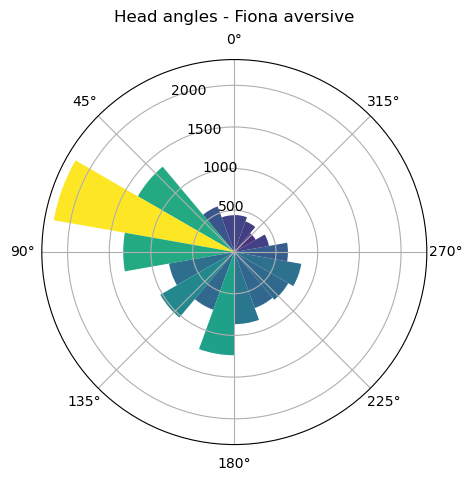

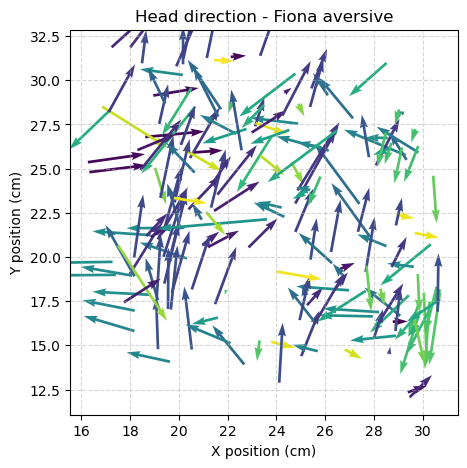

In [ ]:
xmin = 13 
xmax = 23
ymin = 27  
ymax = 12
xlim = [xmin, xmax]
ylim = [ymin, ymax]

fig1, ax1 = plt.subplots(figsize=(5, 5))
mappable = ax1.hist2d(head_x, head_y, bins=15)[3]
ax1.set_title('Histogram - ' + animal_name +' '+ condition)
ax1.set_xlabel('X position (cm)')
ax1.set_ylabel('Y position (cm)')
#ax1.set_xlim(xlim)
#ax1.set_ylim(ylim)
fig1.colorbar(mappable, ax=ax1, label='Incidences')
ax1.invert_yaxis()
figures_to_save[filename1] = fig1

fig2, ax2 = plt.subplots(figsize=(5, 5))
h, xedges, yedges = np.histogram2d(head_x, head_y, bins=15)
im = ax2.imshow(h.T, origin='lower', cmap='magma',
               interpolation='gaussian',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               aspect='auto', vmin=0, vmax=np.max(h))
fig2.colorbar(im, ax=ax2, label='incidences', orientation='vertical', shrink=1.0)
ax2.set_title('Heatmap - ' + animal_name +' '+ condition)
ax2.set_xlabel('X position (cm)')
ax2.set_ylabel('Y position (cm)')
#ax2.set_xlim(xlim)
#ax2.set_ylim(ylim)
ax2.invert_yaxis()
figures_to_save[filename2] = fig2

fig3, ax3 = plt.subplots(figsize=(5, 5))
time = np.arange(len(head_x))
scatter = ax3.scatter(head_x, head_y, c=time, s=1, cmap='viridis')
fig3.colorbar(scatter, ax=ax3, label='Time (frames)')
ax3.set_title('Tracking - ' + animal_name +' '+ condition)
ax3.grid(True, linestyle='--', alpha=0.5)
ax3.set_xlabel('X position (cm)')
ax3.set_ylabel('Y position (cm)')
#ax3.set_xlim(xlim)
#ax3.set_ylim(ylim)
ax3.set_aspect('equal', adjustable='box')
ax3.invert_yaxis()
figures_to_save[filename3] = fig3

fig4, ax4 = plt.subplots(figsize=(5, 5), subplot_kw={'projection': 'polar'})
ax4.bar(theta, radii, width=width, bottom=0.0, color=colors)
ax4.set_theta_zero_location('N')  
ax4.set_theta_direction(1)     
ax4.set_title('Head angles - ' + animal_name +' '+ condition, va='bottom')
plt.show()
figures_to_save[filename4] = fig4

fig5, ax5 = plt.subplots(figsize=(5, 5))
f = 60
ax5.quiver(head_x[::f], head_y[::f],
           dx[::f], dy[::f],
           angles_deg[::f], scale=20, cmap='viridis', width=0.007)
ax5.set_title('Head direction - ' + animal_name +' '+ condition)
ax5.set_xlabel('X position (cm)')
ax5.set_ylabel('Y position (cm)')
ax5.grid(True, linestyle='--', alpha=0.5)
plt.show()
figures_to_save[filename5] = fig5

In [148]:
folder_name = animal_name +' '+ condition
os.makedirs(folder_name, exist_ok=True)

for filename, fig_object in figures_to_save.items():
        full_path = os.path.join(folder_name, filename)

        fig_object.savefig(full_path, dpi=300, bbox_inches='tight')
        print(f"- Figura '{filename}' salva com sucesso.")

- Figura 'histograma_Fiona_aversive_2025-07-03_14-35.png' salva com sucesso.
- Figura 'heatmap_Fiona_aversive_2025-07-03_14-35.png' salva com sucesso.
- Figura 'tracking_Fiona_aversive_2025-07-03_14-35.png' salva com sucesso.
- Figura 'polar_Fiona_aversive_2025-07-03_14-35.png' salva com sucesso.
- Figura 'direction_Fiona_aversive_2025-07-03_14-35.png' salva com sucesso.
